In [19]:
from glob import glob
#change the user_dir to the directory that you unzipped the Supp-Files
path='user-dir/../'
filename='AFEP-Hyd-02.fepout'
fepoutFiles = glob(path+filename)
temperature = 300
RT = 0.00198720650096 * temperature
print(f"Will process {len(fepoutFiles)} fepout files.")

Will process 1 fepout files.


In [20]:
from alchemlyb.parsing import namd
from alchemlyb.estimators import BAR
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from alchemlyb.visualisation.dF_state import plot_dF_state
plt.rcParams['figure.dpi'] = 150

In [21]:
u_nk = namd.extract_u_nk(fepoutFiles, temperature)
bar = BAR()
bar.fit(u_nk)

BAR()

In [22]:
# Extract data for plotting
states = bar.states_

f = bar.delta_f_.iloc[0,:] # dataframe
l = np.array([float(s) for s in states])
# lambda midpoints for each window
l_mid = 0.5*(l[1:] + l[:-1])

# FE differences are off diagonal
df = np.array([bar.delta_f_.iloc[i, i+1] for i in range(len(states)-1)])
#print(df.cumsum() * RT) #in unit of KT
print("Overall free energy",df.cumsum() * 0.59) #in unit of kcal/mol

# error estimates are too small because we use correlated data

tau = 5e2 # expected correlation length of series

# error estimates are off diagonal
ddf = np.array([bar.d_delta_f_.iloc[i, i+1] for i in range(len(states)-1)]) * np.sqrt(tau)

# Accumulate errors as sum of squares
errors = np.array([np.sqrt((ddf[:i]**2).sum()) for i in range(len(states))])
print("Errors", errors)

Overall free energy [0.48665358 0.99677437 1.55385096 2.15712804 2.83664543 3.62920041
 4.50539532 5.25744667 5.71567893 5.83819276 5.76451047 5.68767132
 5.58462217 5.43511067 5.22733177 4.94216237 4.59203113 4.27216242
 4.11412336 4.17818752]
Errors [0.         0.05206786 0.07989019 0.09940862 0.11575719 0.12925338
 0.14017987 0.15060325 0.16076514 0.17029554 0.17888793 0.18309269
 0.18726266 0.19144899 0.19591237 0.20066866 0.2059662  0.2113252
 0.21546732 0.21754345 0.21803461]


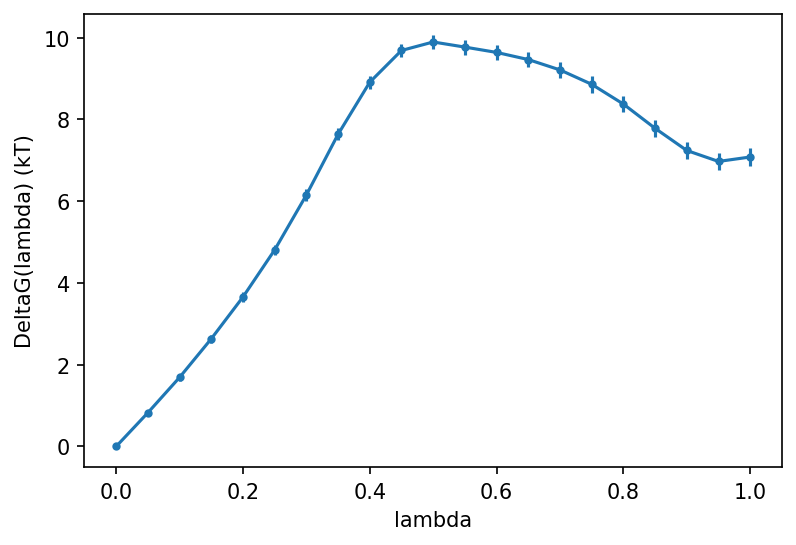

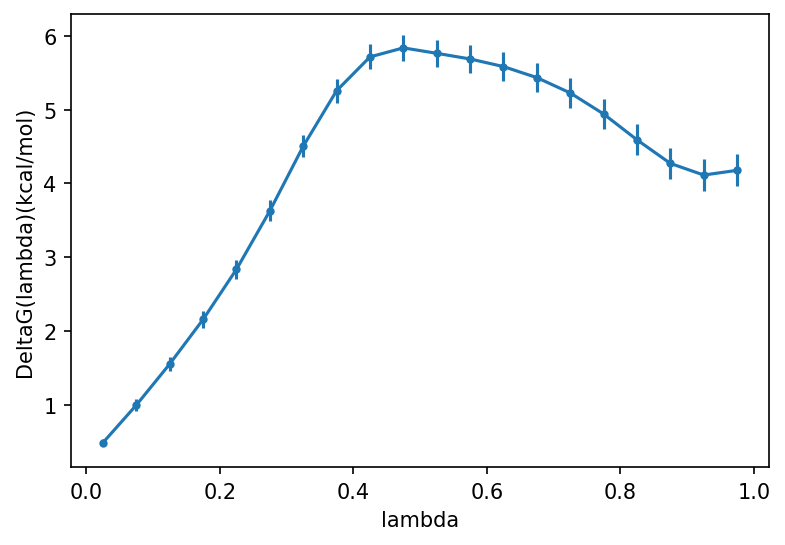

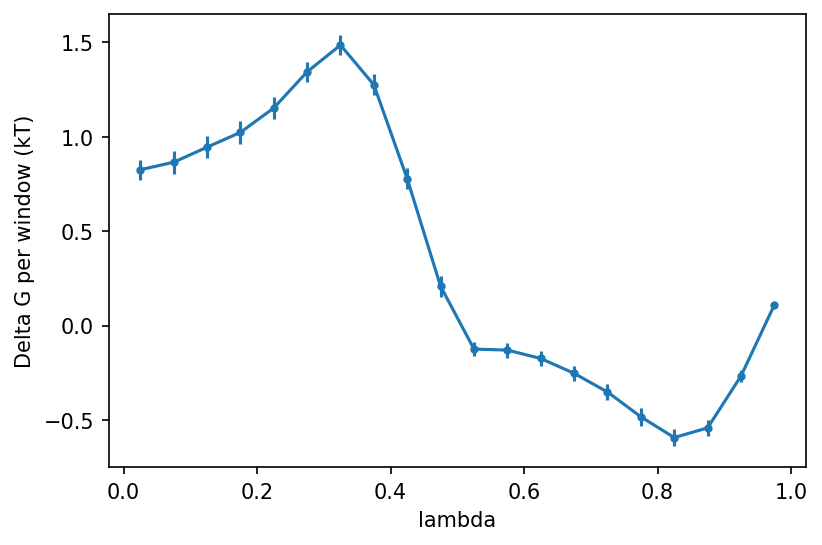

In [23]:
plt.errorbar(l, f, yerr=errors, marker='.')
plt.xlabel('lambda')
plt.ylabel('DeltaG(lambda) (kT)')
plt.show()

plt.errorbar(l_mid, df.cumsum() * 0.59, yerr=errors[1:], marker='.')
plt.xlabel('lambda')
plt.ylabel('DeltaG(lambda)(kcal/mol)')
plt.show()

plt.errorbar(l_mid, df, yerr=ddf, marker='.')
plt.xlabel('lambda')
plt.ylabel('Delta G per window (kT)')
plt.show()


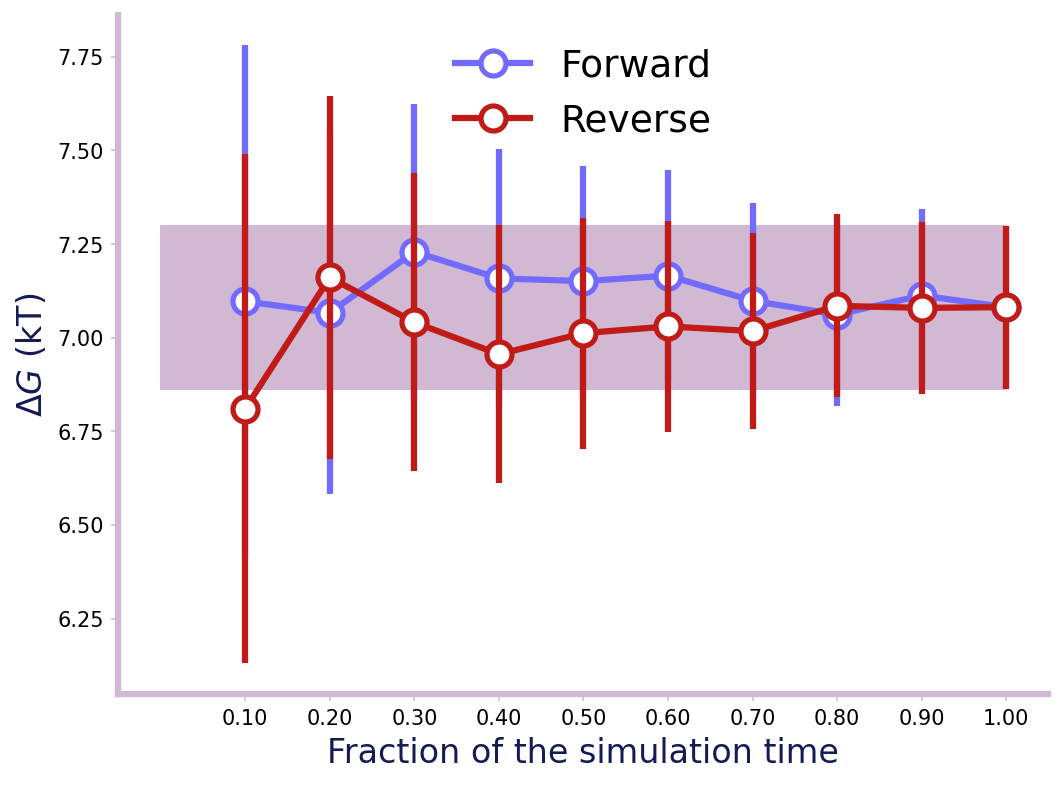

In [24]:
grouped = u_nk.groupby('fep-lambda')
data_list = [grouped.get_group(s) for s in states]

forward = []
forward_error = []
backward = []
backward_error = []
num_points = 10
for i in range(1, num_points+1):
    # forward
    partial = pd.concat([data[:int(len(data)/num_points*i)] for data in data_list])
    estimate = BAR().fit(partial)
    forward.append(estimate.delta_f_.iloc[0,-1])
    # For BAR, the error estimates are off-diagonal
    ddf = [estimate.d_delta_f_.iloc[i+1,i] * np.sqrt(tau) for i in range(len(states)-1)]
    error = np.sqrt((np.array(ddf)**2).sum())
    forward_error.append(error)

    # backward
    partial = pd.concat([data[-int(len(data)/num_points*i):] for data in data_list])
    estimate = BAR().fit(partial)
    backward.append(estimate.delta_f_.iloc[0,-1])
    ddf = [estimate.d_delta_f_.iloc[i+1,i] * np.sqrt(tau) for i in range(len(states)-1)]
    error = np.sqrt((np.array(ddf)**2).sum())
    backward_error.append(error)

from alchemlyb.visualisation import plot_convergence
ax = plot_convergence(forward, forward_error, backward, backward_error)
# ax.set_ylim(-40, -36)

In [25]:
#the data frame is organized from index level 1 (fep-lambda) TO column
#dG will be FROM column TO index
groups = u_nk.groupby(level=1)
dG=pd.DataFrame([])
for name, group in groups:
    dG[name] = np.log(np.mean(np.exp(-1*group)))
    
dG_f=np.diag(dG, k=1)
dG_b=np.diag(dG, k=-1)

l=dG.columns.to_list()
l_mid = np.mean([l[1:],l[:-1]], axis=0)

Text(0, 0.5, 'Diff. in delta-G')

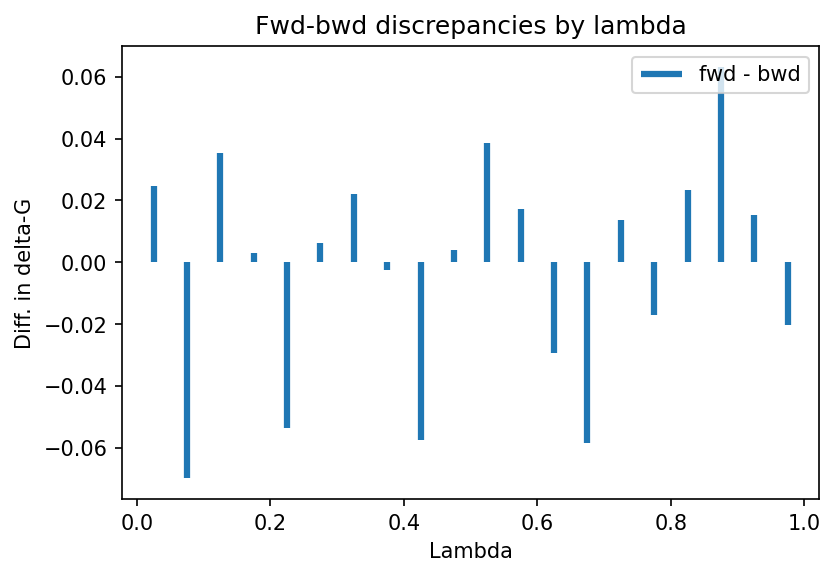

In [26]:
plt.vlines(l_mid, np.zeros(len(l_mid)), dG_f + np.array(dG_b), label="fwd - bwd", linewidth=3)

plt.legend()
plt.title('Fwd-bwd discrepancies by lambda')
plt.xlabel('Lambda')
plt.ylabel('Diff. in delta-G')

Text(0, 0.5, 'Count')

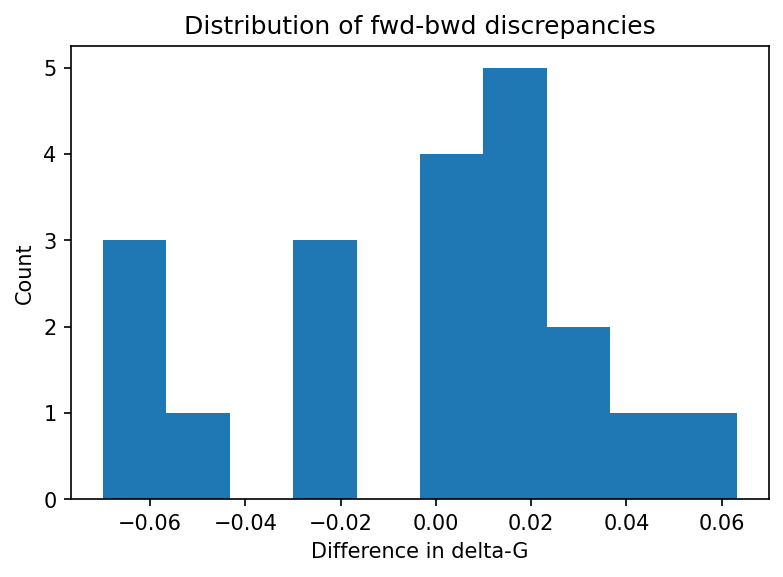

In [27]:
plt.hist(dG_f + np.array(dG_b));
plt.title('Distribution of fwd-bwd discrepancies')
plt.xlabel('Difference in delta-G')
plt.ylabel('Count')